# RLHF with DPO & Hugging Face

This blog post walks you through how to use DPO to improve open LLMs using Hugging Face [TRL](https://huggingface.co/docs/trl/index), [Transformers](https://huggingface.co/docs/transformers/index) & [datasets](https://huggingface.co/docs/datasets/index) in 2024. 

Research and experiments suggest that DPO should only be applied after SFT. This means we need an already fine-tuned LLM, which can be aligned with DPO. In this example we will use [cognitivecomputations/dolphin-2.1-mistral-7b](https://huggingface.co/cognitivecomputations/dolphin-2.1-mistral-7b) a fine-tuned Mistral 7B with ChatML template. 

1. Setup development environment
2. Create and prepare the preference dataset
3. Align LLM with TRL and the DPOTrainer
4. Test LLM (vibe-check)
5. Evaluate open LLMs on MT-Bench


## 1. Setup development environment

`trl` is a library on top of transformers and datasets, which makes it easier to fine-tune, rlhf, align open LLMs.

In [ ]:
# Install Pytorch & other libraries
!pip install "torch==2.1.2" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers[sentencepiece]==4.37.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \
  "trl==0.7.11" \
  "peft==0.8.2" \
  "pillow"

If you are using a GPU with Ampere architecture (e.g. NVIDIA A10G or RTX 4090/3090) or newer, you can use Flash Attention. **[FlashAttention](https://github.com/Dao-AILab/flash-attention/tree/main)** can accelerate training time up to 3x.

In [ ]:
import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'
# install flash-attn
!pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation

_Installing flash attention can take quite a bit of time (10-45 minutes)._

We will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model storage and automatically push our model, logs and information to the Hub during training. You must register on the [Hugging Face](https://huggingface.co/join) for this. After you have an account, we will use the `login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk.

In [ ]:
from huggingface_hub import login

login(
  token="", # ADD YOUR TOKEN HERE
  add_to_git_credential=True
)

## 3. Create and prepare the dataset

In our example, we will use the [argilla/ultrafeedback-binarized-preferences-cleaned](https://huggingface.co/datasets/argilla/ultrafeedback-binarized-preferences-cleaned?row=0) dataset. The best DPO dataset represents the real-world preferences of your users or customers. If you don’t have collected preferences yet, start with your existing SFT data and use different sizes/quality LLMs to generate feedback. This method was used to create the Orca DPO dataset, where GPT-4 was used for the accepted responses and Llama 70B Chat for the rejected responses. A DPO dataset will have the following format

```json
{"chosen": "<prompt + good response>", "rejected": "<prompt + worse response>" }
{"chosen": "<prompt + good response>", "rejected": "<prompt + worse response>" }
{"chosen": "<prompt + good response>", "rejected": "<prompt + worse response>" }
```

The `<pompt + good response>` and `<prompt + worse response>` are representend in the `conversational` format as: 

```json
[{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]
```

_**Note:** If the dataset includes multiple turns you need to make sure that only the last turn between chosen and rejected is different. If not, you must reduce the conversation until only the last assistant turn is different._


The DPOTrainer expects the inputs as triples of (prompt, chosen, rejected), where `chosen` and `rejected` are the final turn of a dialogue and the `prompt` is N-1 turns. Those inputs also need to be already formated with the tempalte of the model, e.g. `<|im_start|>user\nINSTRUCTION\n<|im_end|>\n<|im_start|>assistant\n...`.

In our example we are going to load our open-source dataset using the 🤗 Datasets library and then convert it into the correct format. The  [argilla/ultrafeedback-binarized-preferences-cleaned](https://huggingface.co/datasets/argilla/ultrafeedback-binarized-preferences-cleaned?row=0) already comes with the DPO format (chosen/rejected). This means we can create our triplet and templetite it usng a `tokenizer` and the `apply_chat_template` methoh. We are randomly downsampling the dataset to 11,000 training samples and 2,750 test samples.



In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Load Tokenizer from the hub
model_id = "cognitivecomputations/dolphin-2.1-mistral-7b" # replace with your model id
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load dataset from the hub
dataset = load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned", split="train")
dataset = dataset.shuffle().select(range(13750))


def rec_extract_assistant_messages(messages, index=-1):
  """Recursively extract the last assistant messages from the end of the conversation."""
  if messages[index]["role"] == "assistant":
    return [messages[index]]
  else:
    return rec_extract_assistant_messages(messages, index-1)
    
# System message used if there is no system message at the beginning of the conversation
# Can be repelaced and modified as needed
DEFAULT_SYSTEM_MESSAGE = "You are Dolphin, a helpful AI assistant."

def create_triplets(example, tokenizer, default_system_message=DEFAULT_SYSTEM_MESSAGE):
  """Create the triplets (prompt, chosen, rejected)"""
  # Extract the N-1 turns to form the prompt
  # Prepend a system message if the first message is not a system message
  prompt_messages = example["chosen"][:-1]
  if example["chosen"][0]["role"] != "system":
      prompt_messages.insert(0, {"role": "system", "content": default_system_message})
  # Now we extract the final assistant turn to define chosen/rejected responses 
  chosen_messages = rec_extract_assistant_messages(example["chosen"])
  rejected_messages = rec_extract_assistant_messages(example["rejected"])
  
  # apply template to the messages and return the triplets
  return {
    "prompt": tokenizer.apply_chat_template(prompt_messages, tokenize=False),
    "chosen": tokenizer.apply_chat_template(chosen_messages, tokenize=False),
    "rejected": tokenizer.apply_chat_template(rejected_messages, tokenize=False)
  }

dataset = dataset.map(create_triplets, remove_columns=dataset.features, fn_kwargs={"tokenizer": tokenizer})  
# split dataset into 11,000 training samples and 2,750 test samples
dataset = dataset.train_test_split(test_size=2750/13750)

# print sample cut of 
print(dataset["train"][0]["prompt"][:50])
print(dataset["train"][0]["chosen"][:50])
print(dataset["train"][0]["rejected"][:50])

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

## 4. Align LLM with TRL and the DPOTrainer

TRL supports the DPO through a dedicated [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer) for alinging LLMs from preference data, as described in [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290). The `DPOTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features, including logging, evaluation, and checkpointing. 

One big difference to SFT is that for DPO we need an additional Reference Model, which is used for KL-Divergence to help stabilize the training. The Reference Model is normally the same model as the one we are training, but frozen. This means for DPO you need additional memory and compute resources. To keep our example efficient we will use PEFT and adatpers. We load your fine-tuned and then add a new trainable adapters. This means that we will only tune adapters and not the whole model using DPO. The origian model will be then used as reference model itself. If you want to train all parameter with DPO you need to provide a `model` and `reference_model, but this requires more memory and compute resources.

Lets start by loading our saved datasets from disk. 

In [ ]:
from datasets import load_dataset

# Load jsonl data from disk
train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")
eval_dataset = load_dataset("json", data_files="test_dataset.json", split="train")

We are going to train [cognitivecomputations/dolphin-2.1-mistral-7b](https://huggingface.co/cognitivecomputations/dolphin-2.1-mistral-7b). Dolphin is a fine-tuned Mistral 7B with ChatML template support system messages. You can easily swap out the model for another model, e.g. [Mistral](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) or [Mixtral](https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1) models, TII [Falcon](https://huggingface.co/tiiuae/falcon-40b), or any other LLMs by changing our `model_id` variable.

_Note: Be aware the bigger the model the more memory it will require. In our example we will use the 7B version, which can be tuned on 24GB GPUs. If you have a smaller GPU._

The first step is to load the model in int-4 using `bitsandbytes` and then add 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Hugging Face model id
model_id = "cognitivecomputations/dolphin-2.1-mistral-7b" # replace with your model id

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    use_cache=False, 
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' # to prevent errors with FA
tokenizer.truncation_side = 'left' # to prevent cutting off last generation

Compared to the `SFTTrainer` the DPOTrainer has two parameter related to dataset sizing with `max_prompt_length` and `max_length`. The `max_prompt_length` is the maximum length of the prompt and the `max_length` is the maximum length of the prompt + chosen or rejected response. Those are used for tokenization, padding and trunctation. This means if we set those wrongly our data will be potentially cut off, but if we set them too high we will waste memory and time. 

In [ ]:
#### COMMENT IN TO RECALCULATE MAX LENGTHS ####
# from numpy import percentile

# # lets find the p95 length of the prompt 
# prompt_length = int(percentile([len(tokenizer(x)["input_ids"]) for x in train_dataset["prompt"]], 95))
# max_seq_length_chosen = int(percentile([len(tokenizer(x["prompt"] + x["chosen"])["input_ids"]) for x in train_dataset], 95))
# max_seq_length_rejected = int(percentile([len(tokenizer(x["prompt"] + x["rejected"])["input_ids"]) for x in train_dataset], 95))
# max_seq_length = max(max_seq_length_chosen, max_seq_length_rejected)

# # filter datasets to remove samples that are too long
# train_dataset = train_dataset.filter(lambda x: len(tokenizer(x["prompt"] + x["chosen"])["input_ids"]) <= max_seq_length)
# eval_dataset = eval_dataset.filter(lambda x: len(tokenizer(x["prompt"] + x["chosen"])["input_ids"]) <= max_seq_length)
# print(f"len(train_dataset): {len(train_dataset)}")
# print(f"len(eval_dataset): {len(eval_dataset)}")

# # Up the lengths to next multiple of 2, why 2? Don't know
# prompt_length = ((prompt_length + 1) // 2) * 2
# max_seq_length = ((max_seq_length + 1) // 2) * 2
# print(f"p95 prompt length: {prompt_length}")
# print(f"p95 prompt + chosen length: {max_seq_length}")

prompt_length = 1024
max_seq_length = 1512

_Note: You could reduce the `max_seq_length` to `1512` this would lead to a memory reduction and then increase the batch_size._

The `DPOTrainer` supports a native integration with `peft`, which makes it super easy to efficiently align LLMs using, e.g. QLoRA. We only need to create our `LoraConfig` and provide it to the trainer. Our `LoraConfig` parameters are the same as for the SFT example.

In [ ]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=128,
        lora_dropout=0.05,
        r=256,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM", 
)

Before we can start our training we need to define the hyperparameters (`TrainingArguments`) & DPO parameters.

Based on the [Alignment Handbook](https://github.com/huggingface/alignment-handbook) we know that we need to use a ~10-100x smaller learning rate for DPO compared to SFT. In our example we reduce the learning rate from 2e-4 (SFT) to 5e-5 (DPO) or 40x smaller.  

Another important parameter is the `beta` parameter, which is used to control the strength of the alignment. The bigger the `beta` is typically something in the range of 0.1 to 0.5. A higher beta means less divergence from the initial reference model or the text generations are very similar in terms of their probability distributions. In terms of training length, we go with `1` epoch, which is a good starting point. There is no rule of thumb for the number of epochs, it is also related to the number of epochs used for fine-tuning.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="doplhin-dpo",               # directory to save and repository id
    num_train_epochs=1,                     # number of training epochs
    per_device_train_batch_size=12,         # batch size per device during training
    per_device_eval_batch_size=4,           # batch size for evaluation
    gradient_accumulation_steps=1,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    learning_rate=5e-5,                     # 10x higher LR than QLoRA paper
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.1,                       # warmup ratio based on QLoRA paper
    lr_scheduler_type="cosine",             # use cosine learning rate scheduler
    logging_steps=25,                       # log every 25 steps
    save_steps=500,                         # when to save checkpoint
    save_total_limit=2,                     # limit the total amount of checkpoints
    evaluation_strategy="steps",            # evaluate every 1000 steps
    eval_steps=700,                         # when to evaluate
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    push_to_hub=False,                      # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
)

dpo_args = {
    "beta": 0.1,                            # The beta factor in DPO loss. Higher beta means less divergence
    "loss_type": "sigmoid"                  # The loss type for DPO.
}

We now have every building block we need to create our `DPOTrainer` to start then training our model.

In [ ]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model,
    ref_model=None, # set to none since we use peft
    peft_config=peft_config,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    max_length=max_seq_length,
    max_prompt_length=prompt_length,
    beta=dpo_args["beta"],
    loss_type=dpo_args["loss_type"],
)

Start training our model by calling the `train()` method on our `Trainer` instance. This will start the training loop and train our model for 2 epochs. Since we are using a PEFT method, we will only save the adapted model weights and not the full model.

_Note: During the training we want to minimize loss and grow reward/margins metrics. Keep an eye on the reward/margins metrics, if they are not growing you might need to increase the `beta` parameter or adjust the `learning_rate`._

In [ ]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model at the end of training
trainer.save_model()

The training with Flash Attention for 1 epochs with a dataset of ~10k samples took ~01:30:00 on 1x H100 GPU. You should be able to run the training on a `g5.2xlarge` instance by reducing the batch_size (est. to 1) and maybe the max_seq_length (est. to 1512).

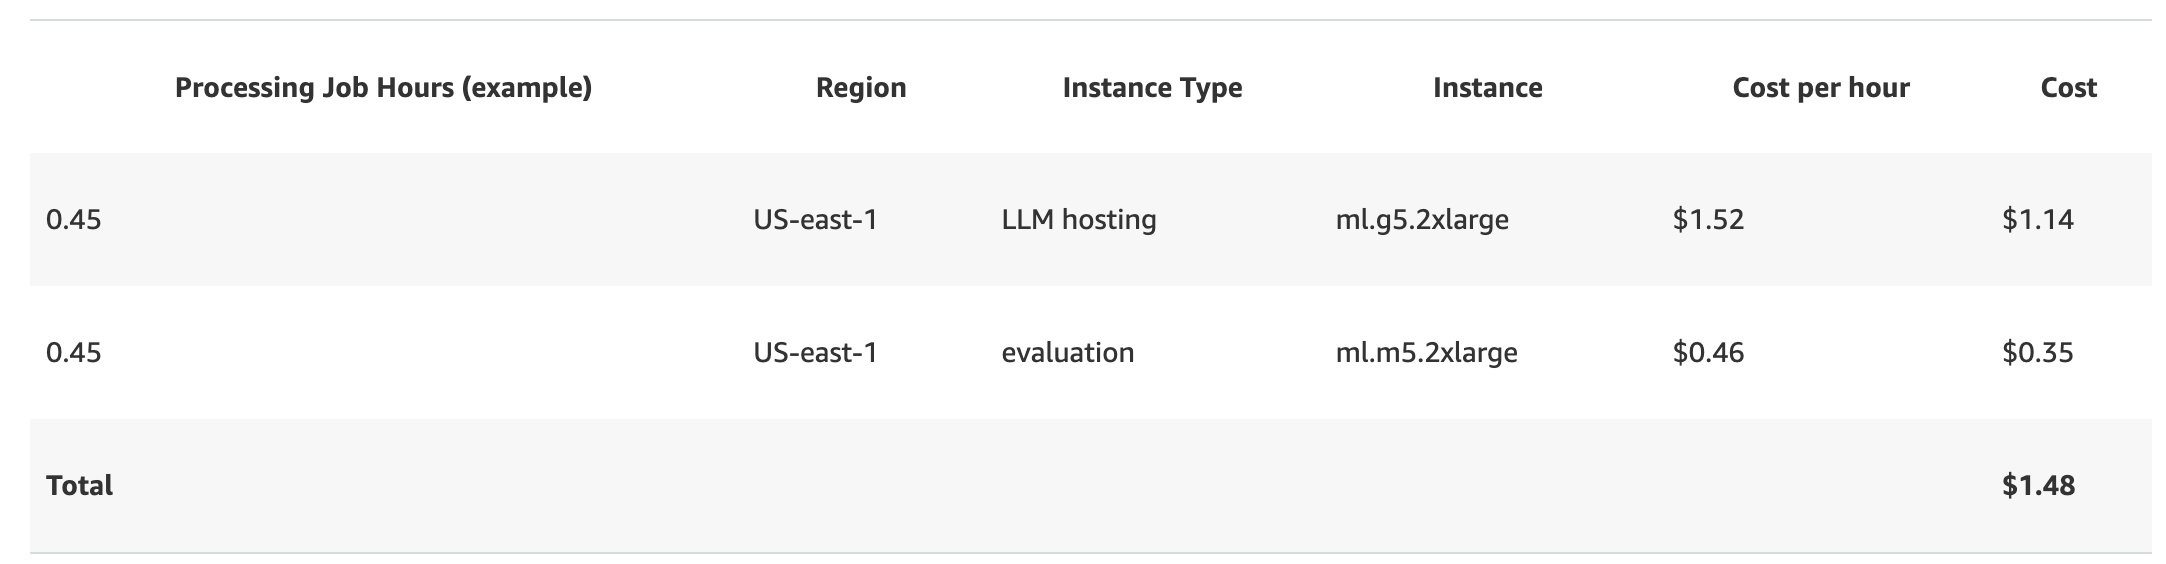

In [ ]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

### _Optional: Merge LoRA adapter in to the original model_

When using QLoRA, we only train adapters and not the full model. This means when saving the model during training we only save the adapter weights and not the full model. If you want to save the full model, which makes it easier to use with Text Generation Inference you can merge the adapter weights into the model weights using the `merge_and_unload` method and then save the model with the `save_pretrained` method. This will save a default model, which can be used for inference.

_Note: You might require > 30GB CPU Memory._

In [ ]:
#### COMMENT IN TO MERGE PEFT AND BASE MODEL ####
# from peft import PeftModel, PeftConfig
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from peft import AutoPeftModelForCausalLM

# # Load PEFT model on CPU
# model = AutoPeftModelForCausalLM.from_pretrained(
#     args.output_dir,
#     torch_dtype=torch.float16,
#     low_cpu_mem_usage=True,
# )  
# # Merge LoRA and base model and save
# merged_model = model.merge_and_unload()
# merged_model.save_pretrained(args.output_dir,safe_serialization=True, max_shard_size="2GB")

# End